### Bayesian Data Analysis, 3rd ed
##  Chapter 10, demo 3

Normal approximaton for Bioassay model.

In [1]:
import numpy as np
from scipy import optimize, stats

%matplotlib inline
import matplotlib.pyplot as plt
import arviz as az

In [2]:
import os, sys
# add utilities directory to path
util_path = os.path.abspath(os.path.join(os.path.pardir, 'utilities_and_data'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

# import from utilities
import psis
import plot_tools

In [3]:
# edit default plot settings
plt.rc('font', size=12)
# apply custom background plotting style
plt.style.use(plot_tools.custom_styles['gray_background'])

In [4]:
# Bioassay data, (BDA3 page 86)
x = np.array([-0.86, -0.30, -0.05, 0.73])
n = np.array([5, 5, 5, 5])
y = np.array([0, 1, 3, 5])

In [5]:
# compute the posterior density in grid
#  - usually should be computed in logarithms!
#  - with alternative prior, check that range and spacing of A and B
#    are sensible
ngrid = 100
A = np.linspace(-4, 8, ngrid)
B = np.linspace(-10, 40, ngrid)
ilogit_abx = 1 / (np.exp(-(A[:,None] + B[:,None,None] * x)) + 1)
p = np.prod(ilogit_abx**y * (1 - ilogit_abx)**(n - y), axis=2)

In [6]:
# sample from the grid
nsamp = 1000
samp_indices = np.unravel_index(
    np.random.choice(p.size, size=nsamp, p=p.ravel()/np.sum(p)),
    p.shape
)
samp_A = A[samp_indices[1]]
samp_B = B[samp_indices[0]]
# add random jitter, see BDA3 p. 76
samp_A += (np.random.rand(nsamp) - 0.5) * (A[1]-A[0])
samp_B += (np.random.rand(nsamp) - 0.5) * (B[1]-B[0])

# samples of LD50
samp_ld50 = -samp_A / samp_B

Find the mode by minimising negative log posterior. Compute gradients and Hessian analytically, and use Newton's method for optimisation. You may use optimisation routines below for checking your results. See help for scipy.optimize.minimize.

In [7]:
# define the optimised function
def bioassayfun(w):
    a = w[0]
    b = w[1]
    et = np.exp(a + b * x)
    z = et / (1 + et)
    e = - np.sum(y * np.log(z) + (n - y) * np.log(1 - z))
    return e
# initial guess
w0 = np.array([0.0, 0.0])
# optimise
optim_res = optimize.minimize(bioassayfun, w0)
# extract desired results
w = optim_res['x']
S = optim_res['hess_inv']

Compute the normal approximation density in grid. Note tha this is just for the illustration and in real case we would not need to evaluate this, and we would only use the draws from the normal distribution approaximation.

In [8]:
# Construct a grid array of shape (ngrid, ngrid, 2) from A and B. Although
# Numpy's concatenation functions do not support broadcasting, a clever trick
# can be applied to overcome this without unnecessary memory copies
# (see Numpy's documentation for strides for more information):
A_broadcasted = np.lib.stride_tricks.as_strided(
    A, shape=(ngrid,ngrid), strides=(0, A.strides[0]))
B_broadcasted = np.lib.stride_tricks.as_strided(
    B, shape=(ngrid,ngrid), strides=(B.strides[0], 0))
grid = np.dstack((A_broadcasted, B_broadcasted))
p_norm = stats.multivariate_normal.pdf(x=grid, mean=w, cov=S)

# draw samples from the distribution
samp_norm = stats.multivariate_normal.rvs(mean=w, cov=S, size=1000)

Compute Pareto smoothed importance sampling weights and Pareto diagnostic

In [9]:
lg = stats.multivariate_normal.logpdf(x=samp_norm, mean=w, cov=S)
Ar = samp_norm[:,0]
Br = samp_norm[:,1]
ilogit_abx = 1 / (np.exp(-(Ar[:,None] + Br[:,None] * x)) + 1)
lp = np.sum(np.log(ilogit_abx**y * (1 - ilogit_abx)**(n - y)), axis=1)
lw = lp - lg
lw, pk = psis.psislw(lw)
print("Pareto khat is {:.2}".format(pk))

Pareto khat is 0.58


Importance sampling weights could be used to weight different expectations directly, but for visualisation and easy computation of LD50 histogram, we use resampling importance sampling.

In [10]:
# resampling importance sampling
pis = np.exp(lw)
nsamp = 1000
samp_indices = np.random.choice(pis.size, size=nsamp, p=pis)
rissamp_A = Ar[samp_indices]
rissamp_B = Br[samp_indices]
# add random jitter, see BDA3 p. 76
rissamp_A += (np.random.rand(nsamp) - 0.5) * (A[1]-A[0])
rissamp_B += (np.random.rand(nsamp) - 0.5) * (B[1]-B[0])

# samples of LD50
rissamp_ld50 = - rissamp_A / rissamp_B

Create figure with all results

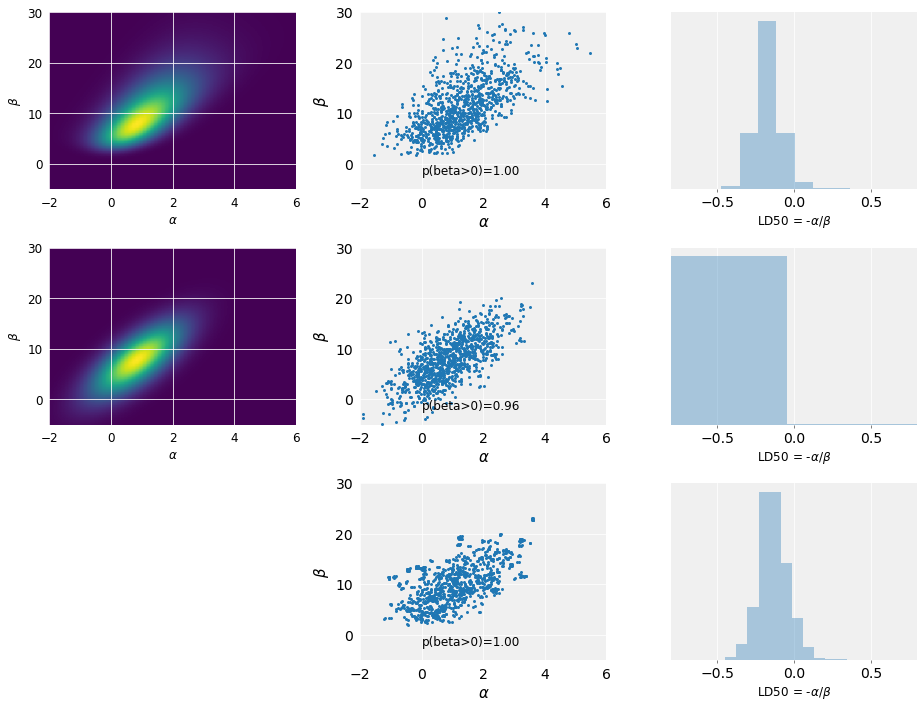

In [11]:
fig, axes = plt.subplots(3, 3, figsize=(13, 10))

# convert samples to InferenceData for plotting
samples = az.convert_to_inference_data({"A": samp_A, "B": samp_B})

samples_norm = az.convert_to_inference_data({"A": samp_norm[:, 0], "B": samp_norm[:, 1]})


rissamples = az.convert_to_inference_data({"A" : rissamp_A, "B" : rissamp_B})

# plot the posterior density
ax = axes[0, 0]
ax.imshow(
    p,
    origin='lower',
    aspect='auto',
    extent=(A[0], A[-1], B[0], B[-1])
)
ax.set_xlim([-2, 6])
ax.set_ylim([-5, 30])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.grid('off')
ax.set_yticks(np.linspace(0, 30, 4))


# plot the samples
ax = axes[0, 1]
az.plot_pair(samples, marginals=False, ax=ax)
ax.set_xlim([-2, 6])
ax.set_ylim([-5, 30])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.text(0, -2, 'p(beta>0)={:.2f}'.format(np.mean(samp_B>0)))
ax.set_yticks(np.linspace(0, 30, 4))


# plot the histogram of LD50
ax = axes[0, 2]
#ax.hist(samp_ld50, np.linspace(-0.8, 0.8, 31))
az.plot_posterior(samp_ld50, kind="hist", point_estimate=None, hdi_prob="hide", ax=ax)
ax.set_xlim([-0.8, 0.8])
ax.set_title("")
ax.set_xlabel(r'LD50 = -$\alpha/\beta$')
ax.set_yticks(())
ax.set_xticks(np.linspace(-0.5, 0.5, 3))

# plot the posterior density for normal approx.
ax = axes[1, 0]
ax.imshow(
    p_norm,
    origin='lower',
    aspect='auto',
    extent=(A[0], A[-1], B[0], B[-1])
)
ax.set_xlim([-2, 6])
ax.set_ylim([-5, 30])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.grid('off')
ax.set_yticks(np.linspace(0, 30, 4))


# plot the samples from the normal approx.
ax = axes[1, 1]
az.plot_pair(samples_norm, marginals=False, ax=ax)
ax.set_xlim([-2, 6])
ax.set_ylim([-5, 30])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.set_yticks(np.linspace(0, 30, 4))


# Normal approximation does not take into account that the posterior
# is not symmetric and that there is very low density for negative
# beta values. Based on the samples from the normal approximation
# it is estimated that there is about 4% probability that beta is negative!
ax.text(0, -2, 'p(beta>0)={:.2f}'.format(np.mean(samp_norm[:,1]>0)))

# Plot the histogram of LD50
ax = axes[1, 2]
# Since we have strong prior belief that beta should not be negative we can
# improve our normal approximation by conditioning on beta>0.
bpi = samp_norm[:,1] > 0
samp_ld50_norm = - samp_norm[bpi,0] / samp_norm[bpi,1]
az.plot_posterior(samp_ld50_norm, kind="hist", point_estimate=None, hdi_prob="hide", ax=ax)
ax.set_xlim([-0.8, 0.8])
ax.set_title("")
ax.set_xlabel(r'LD50 = -$\alpha/\beta$')
ax.set_yticks(())
ax.set_xticks(np.linspace(-0.5, 0.5, 3))

# plot the samples from the resampling importance sampling
ax = axes[2, 1]
az.plot_pair(rissamples, marginals=False, ax=ax)
ax.set_xlim([-2, 6])
ax.set_ylim([-5, 30])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.set_yticks(np.linspace(0, 30, 4))


# Importance sampling is able to improve the estimate of p(beta>0)
ax.text(0, -2, 'p(beta>0)={:.2f}'.format(np.mean(rissamp_B>0)))

# Plot the histogram of LD50
ax = axes[2, 2]
az.plot_posterior(rissamp_ld50, kind="hist", point_estimate=None, hdi_prob="hide", ax=ax)
ax.set_title("")
ax.set_xlim([-0.8, 0.8])
ax.set_xlabel(r'LD50 = -$\alpha/\beta$')
ax.set_yticks(())
ax.set_xticks(np.linspace(-0.5, 0.5, 3))

# hide unused subplot
axes[2, 0].axis('off')

fig.tight_layout()

We can see that normal approximation centered at the posterior mode is able to catch some of the posterior shape, but the gives much larger value for $p(\beta>0)$ and longer tails for the marginal posterior of LD50. The importance sampling is able to partially correct the normal approaximation, although it's clearly missing part of the mass in long tail of the true distribution, but still we get much improved approximation for the marginal posterior of LD50.